In [2]:
from alignscore import AlignScore

scorer = AlignScore(model='roberta-large', batch_size=32, device='cuda:2', ckpt_path='../backup/AlignScore/AlignScore-large.ckpt', evaluation_mode='nli_sp')
score = scorer.score(contexts=['hello world.'], claims=['hello world.'])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/user/rosni/miniconda2/envs/scigen/lib/python3.8/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

In [3]:
import json
from datasets import Dataset, DatasetDict
def load_dataset(data_path):
    with open(data_path, 'r') as f:
        d = json.load(f)
    metadata_fields = ["file_name", "chain_label", "chain_source", "file_path", "generated_from_split", "target_hypothesis"]
    chains = []
    meta_chains = []
    label_papers = []
    for data in d:
        if data['content'][-1]['year'] == 2024:
            metadata = {key: data.get(key) for key in metadata_fields}
            meta_chains.append(metadata)
            chains.append(data['content'][:-1])
            label_papers.append(data['content'][-1])
    return meta_chains, chains, label_papers

data_path = "../ground_truth_dataset/balanced_splits_w_hyp/test_hyp.json"
meta_chains, chains, labels = load_dataset(data_path) 
print(len(chains))
source_paper = chains[0][0]
print(source_paper)


136
{'paperId': '1017a936c5b937841f86b1d00d8c84c8edab2845', 'pmid': '11519503', 'title': 'Effects of clopidogrel in addition to aspirin in patients with acute coronary syndromes without ST-segment elevation.', 'abstract': 'BACKGROUND\nDespite current treatments, patients who have acute coronary syndromes without ST-segment elevation have high rates of major vascular events. We evaluated the efficacy and safety of the antiplatelet agent clopidogrel when given with aspirin in such patients.\n\n\nMETHODS\nWe randomly assigned 12,562 patients who had presented within 24 hours after the onset of symptoms to receive clopidogrel (300 mg immediately, followed by 75 mg once daily) (6259 patients) or placebo (6303 patients) in addition to aspirin for 3 to 12 months.\n\n\nRESULTS\nThe first primary outcome--a composite of death from cardiovascular causes, nonfatal myocardial infarction, or stroke--occurred in 9.3 percent of the patients in the clopidogrel group and 11.4 percent of the patients in

In [ ]:
import pandas as pd
import json

with open("final_hyper.json", "r") as f:
# Load dataset
#with open("phi3-base_test.json", "r") as f:
    data = json.load(f)


# Initialize lists to store extracted values
file_names = []
chain_labels = []
novelty_scores = []
alignment_scores_list1 = []
alignment_scores_list2 = []
chain_lengths = []
contexts = []
# Process data
for entry in data:
    metadata = entry["metadata"]
    file_name = metadata["file_name"]
    chain_label = metadata["chain_label"]  # 'valid' or 'invalid'
    
    # Extract novelty analysis
    novelty_analysis = entry["novelty_analysis"]

    novelty_score = novelty_analysis.get("novelty_result", {})  # Default to 'not novel'
    if novelty_score is None or not novelty_score.strip().startswith("{"):  # Avoid parsing if not valid JSON
        novelty_score = '{"Novelty score": null}'  # Assign a default JSON structure

    novelty_score = json.loads(novelty_score)
    
    # Extract alignment score
    generated_hypothesis = entry["generated_research_idea"]["Hypothesis"]
    target_hypothesis = " ".join(metadata["target_hypothesis"]["Target Hypotheses"])
    
    original_chain = entry.get("original_chain", [])
    concatenated_text = " ".join([f"({i+1}) {paper['title']} {paper['abstract']}" for i, paper in enumerate(original_chain)])
    if not generated_hypothesis or generated_hypothesis.strip() == "":
        continue
    
    # Lookup computed alignment score
    score1 = scorer.score(contexts=[target_hypothesis], claims=[generated_hypothesis])[0]  # Extract score
    score2 = scorer.score(contexts=[concatenated_text], claims=[generated_hypothesis])[0]  # Extract score

    chain_lengths.append(len(original_chain)-1)
    
    # Append to lists
    file_names.append(file_name)
    chain_labels.append(chain_label)
    novelty_scores.append(novelty_score["Novelty score"])
    alignment_scores_list1.append(score1)
    alignment_scores_list2.append(score2)
    contexts.append(concatenated_text)
    
# Create DataFrame
df_hyper = pd.DataFrame({
    "file_name": file_names,
    "chain_label": chain_labels,
    "context": contexts,
    "novelty_score": novelty_scores,
    "alignment_score_TH": alignment_scores_list1,
    "alignment_score_CT": alignment_scores_list2,
    "chain_length": chain_lengths
})




In [ ]:
import pandas as pd
import json

#with open("phi3-hyper-test2_normal.json", "r") as f:
with open("phi3-base_test.json", "r") as f:
    data = json.load(f)
    
# Initialize lists to store extracted values
file_names = []
chain_labels = []
novelty_scores = []
alignment_scores_list1 = []
alignment_scores_list2 = []
chain_lengths = []
contexts = []
# Process data

for entry in data:
    metadata = entry["metadata"]
    file_name = metadata["file_name"]
    chain_label = metadata["chain_label"]  # 'valid' or 'invalid'
    
    # Extract novelty analysis
    novelty_analysis = entry["novelty_analysis"]

    novelty_score = novelty_analysis.get("novelty_result", {})  # Default to 'not novel'
    if novelty_score is None or not novelty_score.strip().startswith("{"):  # Avoid parsing if not valid JSON
        novelty_score = '{"Novelty score": null}'  # Assign a default JSON structure

    novelty_score = json.loads(novelty_score)
    
    # Extract alignment score
    generated_hypothesis = entry["generated_research_idea"]["Hypothesis"]
    target_hypothesis = " ".join(metadata["target_hypothesis"]["Target Hypotheses"])
    
    original_chain = entry.get("original_chain", [])
    concatenated_text = " ".join([f"({i+1}) {paper['title']} {paper['abstract']}" for i, paper in enumerate(original_chain)])
    if not generated_hypothesis or generated_hypothesis.strip() == "":
        continue
    
    # Lookup computed alignment score
    score1 = scorer.score(contexts=[target_hypothesis], claims=[generated_hypothesis])[0]  # Extract score
    score2 = scorer.score(contexts=[concatenated_text], claims=[generated_hypothesis])[0]  # Extract score

    chain_lengths.append(len(original_chain)-1)
    
    # Append to lists
    file_names.append(file_name)
    chain_labels.append(chain_label)
    novelty_scores.append(novelty_score["Novelty score"])
    alignment_scores_list1.append(score1)
    alignment_scores_list2.append(score2)
    contexts.append(concatenated_text)
    
# Create DataFrame
df_base = pd.DataFrame({
    "file_name": file_names,
    "chain_label": chain_labels,
    "context": contexts,
    "novelty_score": novelty_scores,
    "alignment_score_TH": alignment_scores_list1,
    "alignment_score_CT": alignment_scores_list2,
    "chain_length": chain_lengths
})




In [ ]:
import pandas as pd
import json

# Load dataset
#with open("phi3-hyper-test.json", "r") as f:
with open("phi3-base_test.json", "r") as f:
    data = json.load(f)

#output_file = "alignscore_hyper.csv"

# Initialize lists to store extracted values
file_names = []
chain_labels = []
explanation_groundedness_scores = []
chain_lengths = []
explanations = []
contexts = []
original_chains = []

# Process data
for entry in data:
    # Extract generated explanation (assume it's under 'generated_research_idea' -> 'Explanation')
    generated_analysis = json.dumps(entry["generated_research_idea"].get("Analysis", {}), indent=2)  # Convert to string
    generated_explanation = entry["generated_research_idea"].get("Rationale", "")
    generated_idea = entry["generated_research_idea"].get("Research idea", "")
    generated_hypothesis = entry["generated_research_idea"].get("Hypothesis", "")

    # Combine all components into a single explanation string
    generated_full_explanation = f"{generated_explanation}\n{generated_idea}\n{generated_hypothesis}"
    if not generated_full_explanation.strip():
        print(f"Skipping {file_name} due to missing explanation")
        continue
    
    metadata = entry["metadata"]
    file_name = metadata["file_name"]
    chain_label = metadata["chain_label"]  # 'valid' or 'invalid'
    
    # Extract original reasoning chain
    original_chain = entry.get("original_chain", [])
    context = " ".join([f"({i+1}) {paper['title']} {paper['abstract']}" for i, paper in enumerate(original_chain)])
    
    if chain_label == "valid":
        reasoning_context = context
        align_score1 = scorer.score(
            contexts=[reasoning_context],  # The full reasoning chain
            claims=[generated_full_explanation]
        )[0]   # Extract score
        align_score2 = 0
        
    
    elif chain_label == "invalid_type2":
        valid_nodes = []
        invalid_nodes = []
        found_invalid = False  # Flag to detect the first invalid node

        for paper in original_chain:
            if paper.get("relevance", 1) == 0 and not found_invalid:
                found_invalid = True  # Mark that we've found the first invalid node
        
            if not found_invalid:
                valid_nodes.append(f"({len(valid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")
            else:
                invalid_nodes.append(f"({len(invalid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")
               
        # Create reasoning contexts
        valid_context = " ".join(valid_nodes) if valid_nodes else None
        invalid_context = " ".join(invalid_nodes) if invalid_nodes else None
        
        align_score1 = scorer.score(
                contexts=[valid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
        align_score2 = scorer.score(
                contexts=[invalid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
    elif chain_label == "invalid_type1":
        valid_nodes = []
        invalid_nodes = []

        for paper in original_chain:
            if paper.get("relevance", 1) == 0:
                invalid_nodes.append(f"({len(invalid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")
            else:
                valid_nodes.append(f"({len(valid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")

        # Create reasoning contexts
        valid_context = " ".join(valid_nodes) if valid_nodes else None
        invalid_context = " ".join(invalid_nodes) if invalid_nodes else None
        
        
        align_score1 = scorer.score(
                contexts=[valid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
        align_score2 = scorer.score(
                contexts=[invalid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
    
    # Compute Explanation Groundedness using alignment score
    explanation_groundedness_score = (align_score1, align_score2)

    print(explanation_groundedness_score)
    
    # Append to lists
    file_names.append(file_name)
    chain_labels.append(chain_label)
    explanation_groundedness_scores.append(explanation_groundedness_score)
    chain_lengths.append(len(original_chain) - 1)  # Chain length excluding source paper
    contexts.append(context)
    explanations.append(generated_full_explanation)
    original_chains.append(original_chain)
    
# Create DataFrame
df_align_base = pd.DataFrame({
    "file_name": file_names,
    "chain_label": chain_labels,
    "original_chains": original_chains,
    "context": contexts,
    "explanation": explanations,
    "explanation_groundedness": explanation_groundedness_scores,
    "chain_length": chain_lengths
})

#df_align.to_csv(output_file, index=False)
#print(f"Results saved to {output_file}")

In [ ]:
import pandas as pd
import json

# Load dataset
with open("final_hyper.json", "r") as f:
#with open("phi3-base_test.json", "r") as f:
    data = json.load(f)

#output_file = "alignscore_hyper.csv"

# Initialize lists to store extracted values
file_names = []
chain_labels = []
explanation_groundedness_scores = []
chain_lengths = []
explanations = []
contexts = []
original_chains = []

# Process data
for entry in data:
    # Extract generated explanation (assume it's under 'generated_research_idea' -> 'Explanation')
    generated_analysis = json.dumps(entry["generated_research_idea"].get("Analysis", {}), indent=2)  # Convert to string
    generated_explanation = entry["generated_research_idea"].get("Rationale", "")
    generated_idea = entry["generated_research_idea"].get("Research idea", "")
    generated_hypothesis = entry["generated_research_idea"].get("Hypothesis", "")

    # Combine all components into a single explanation string
    generated_full_explanation = f"{generated_explanation}\n{generated_idea}\n{generated_hypothesis}"
    if not generated_full_explanation.strip():
        print(f"Skipping {file_name} due to missing explanation")
        continue
    
    metadata = entry["metadata"]
    file_name = metadata["file_name"]
    chain_label = metadata["chain_label"]  # 'valid' or 'invalid'
    
    # Extract original reasoning chain
    original_chain = entry.get("original_chain", [])
    context = " ".join([f"({i+1}) {paper['title']} {paper['abstract']}" for i, paper in enumerate(original_chain)])
    
    if chain_label == "valid":
        reasoning_context = context
        align_score1 = scorer.score(
            contexts=[reasoning_context],  # The full reasoning chain
            claims=[generated_full_explanation]
        )[0]   # Extract score
        align_score2 = 0
        
    
    elif chain_label == "invalid_type2":
        valid_nodes = []
        invalid_nodes = []
        found_invalid = False  # Flag to detect the first invalid node

        for paper in original_chain:
            if paper.get("relevance", 1) == 0 and not found_invalid:
                found_invalid = True  # Mark that we've found the first invalid node
        
            if not found_invalid:
                valid_nodes.append(f"({len(valid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")
            else:
                invalid_nodes.append(f"({len(invalid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")
               
        # Create reasoning contexts
        valid_context = " ".join(valid_nodes) if valid_nodes else None
        invalid_context = " ".join(invalid_nodes) if invalid_nodes else None
        
        align_score1 = scorer.score(
                contexts=[valid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
        align_score2 = scorer.score(
                contexts=[invalid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
    elif chain_label == "invalid_type1":
        valid_nodes = []
        invalid_nodes = []

        for paper in original_chain:
            if paper.get("relevance", 1) == 0:
                invalid_nodes.append(f"({len(invalid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")
            else:
                valid_nodes.append(f"({len(valid_nodes) + 1}) {paper['title']} {paper.get('abstract', '')}")

        # Create reasoning contexts
        valid_context = " ".join(valid_nodes) if valid_nodes else None
        invalid_context = " ".join(invalid_nodes) if invalid_nodes else None
        
        
        align_score1 = scorer.score(
                contexts=[valid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
        align_score2 = scorer.score(
                contexts=[invalid_context],  # The full reasoning chain
                claims=[generated_full_explanation]
            )[0]   # Extract score
        
    
    # Compute Explanation Groundedness using alignment score
    explanation_groundedness_score = (align_score1, align_score2)

    print(explanation_groundedness_score)
    
    # Append to lists
    file_names.append(file_name)
    chain_labels.append(chain_label)
    explanation_groundedness_scores.append(explanation_groundedness_score)
    chain_lengths.append(len(original_chain) - 1)  # Chain length excluding source paper
    contexts.append(context)
    explanations.append(generated_full_explanation)
    original_chains.append(original_chain)
    
# Create DataFrame
df_align_hyper = pd.DataFrame({
    "file_name": file_names,
    "chain_label": chain_labels,
    "original_chains": original_chains,
    "context": contexts,
    "explanation": explanations,
    "explanation_groundedness": explanation_groundedness_scores,
    "chain_length": chain_lengths
})

#output_file = "alignscore_hyper.csv"
#df_align_hyper.to_csv(output_file, index=False)
#print(f"Results saved to {output_file}")

In [16]:
output_file = "alignscore_base.csv"
df_align_base.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to alignscore_base.csv


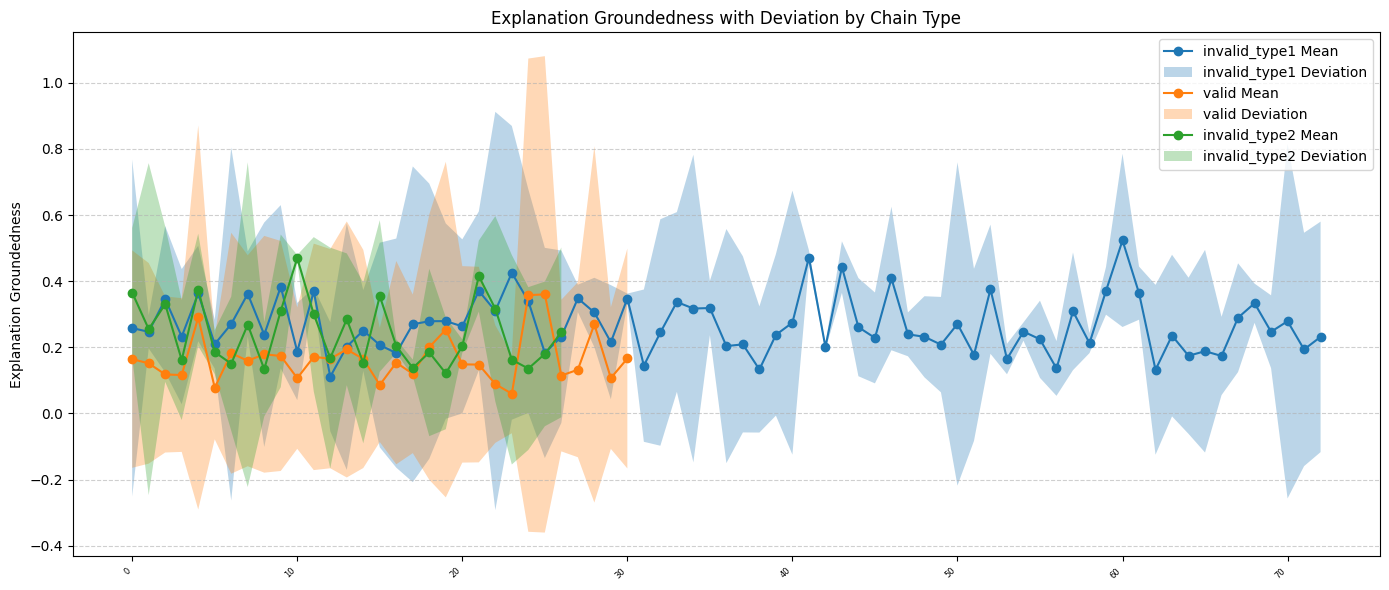

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Copy dataframe
df = df_align_hyper.copy()

# Extract values from the explanation_groundedness column
df['value1'] = df['explanation_groundedness'].apply(lambda x: x[0])
df['value2'] = df['explanation_groundedness'].apply(lambda x: x[1])

# Calculate the mean and deviation as the absolute difference
df['mean'] = (df['value1'] + df['value2']) / 2
df['deviation'] = abs(df['value1'] - df['value2'])

# Prepare for plotting
unique_labels = df['chain_label'].unique()
plt.figure(figsize=(14, 6))

# Plot each chain_label group separately for better clarity
for label in unique_labels:
    subset = df[df['chain_label'] == label]
    x = np.arange(len(subset))
    means = subset['mean']
    deviations = subset['deviation']
    plt.plot(x, means, marker='o', linestyle='-', label=f'{label} Mean')
    plt.fill_between(x, means - deviations, means + deviations, alpha=0.3, label=f'{label} Deviation')

# Adjust x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=6)

# Add grid, title, and legend
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylabel('Explanation Groundedness')
plt.title('Explanation Groundedness with Deviation by Chain Type')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from scipy.stats import ttest_rel

# Merge based on common filenames
df_merged = df_align_base.merge(df_align_hyper, on=["context", "chain_label"], suffixes=("_base", "_hyper"))

# Display how many matching entries we have
print(f"Total matching entries: {len(df_merged)}")


Total matching entries: 134


In [24]:
import numpy as np

df_valid = df_merged[df_merged["chain_label"] == "invalid_type2"]

# Extract the first and second elements separately
first_items = [x[0] for x in df_valid["explanation_groundedness_base"]]
second_items = [x[1] for x in df_valid["explanation_groundedness_base"]]

mean_first = round(np.mean(first_items), 3)
std_first = round(np.std(first_items), 2)

mean_second = round(np.mean(second_items), 3)
std_second = round(np.std(second_items), 2)

# Display results
print(f"First Item - Mean: {mean_first}, Std: {std_first}")
print(f"Second Item - Mean: {mean_second}, Std: {std_second}")


First Item - Mean: 0.269, Std: 0.14
Second Item - Mean: 0.187, Std: 0.12


In [25]:
import numpy as np

df_valid = df_merged[df_merged["chain_label"] == "invalid_type1"]

# Extract the first and second elements separately
first_items = [x[0] for x in df_valid["explanation_groundedness_hyper"]]
second_items = [x[1] for x in df_valid["explanation_groundedness_hyper"]]

mean_first = round(np.mean(first_items), 3)
std_first = round(np.std(first_items), 2)

mean_second = round(np.mean(second_items), 3)
std_second = round(np.std(second_items), 2)

# Display results
print(f"First Item - Mean: {mean_first}, Std: {std_first}")
print(f"Second Item - Mean: {mean_second}, Std: {std_second}")


First Item - Mean: 0.364, Std: 0.11
Second Item - Mean: 0.164, Std: 0.12


In [19]:
df_base[df_base["chain_label"] == "invalid_type2"]["novelty_score"].value_counts()


novelty_score
novel        19
not novel     7
Novel         1
Name: count, dtype: int64

In [20]:
df_hyper[df_hyper["chain_label"] == "invalid_type2"]["novelty_score"].value_counts()


novelty_score
not novel    15
novel         9
Novel         2
Name: count, dtype: int64

<Figure size 800x500 with 0 Axes>

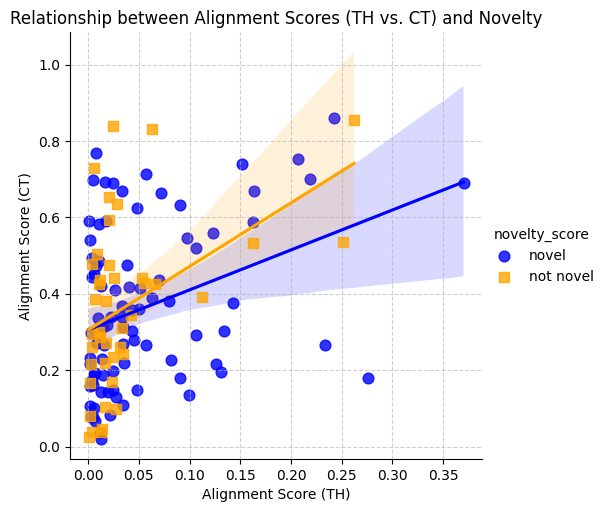

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = df_base.copy()
# Ensure alignment scores are numeric
df["alignment_score_TH"] = df["alignment_score_TH"].astype(float)
df["alignment_score_CT"] = df["alignment_score_CT"].astype(float)

df["novelty_score"] = df["novelty_score"].str.lower()
df = df[df["novelty_score"].isin(["novel", "not novel"])]

# Convert novelty_score into a binary numeric variable for statistical use
df["novelty_numeric"] = df["novelty_score"].map({"novel": 1, "not novel": 0})

# Encode chain labels numerically for consistency
label_encoder = LabelEncoder()
df["chain_label_encoded"] = label_encoder.fit_transform(df["chain_label"])

### 🔹 Scatter Plot with Regression Line (TH vs. CT) ###
plt.figure(figsize=(8, 5))
sns.lmplot(
    x="alignment_score_TH",
    y="alignment_score_CT",
    hue="novelty_score",
    data=df,
    palette={"novel": "blue", "not novel": "orange"},
    scatter_kws={"s": 60, "alpha": 0.8},
    markers=["o", "s"]
)

plt.title("Relationship between Alignment Scores (TH vs. CT) and Novelty", fontsize=12)
plt.xlabel("Alignment Score (TH)", fontsize=10)
plt.ylabel("Alignment Score (CT)", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



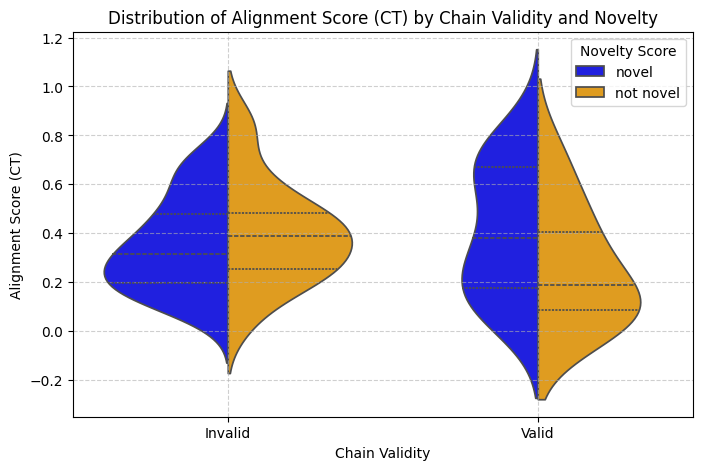

In [25]:

# Define chain validity categories
df["validity_label"] = df["chain_label"].apply(lambda x: "Valid" if x == "valid" else "Invalid")


# Create a Violin Plot for Alignment Score CT
plt.figure(figsize=(8, 5))
sns.violinplot(
    x="validity_label",
    y="alignment_score_CT",
    hue="novelty_score",
    data=df,
    palette={"novel": "blue", "not novel": "orange"},
    split=True,
    inner="quartile"
)

plt.title("Distribution of Alignment Score (CT) by Chain Validity and Novelty", fontsize=12)
plt.xlabel("Chain Validity", fontsize=10)
plt.ylabel("Alignment Score (CT)", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Novelty Score")
plt.show()



<Figure size 800x700 with 0 Axes>

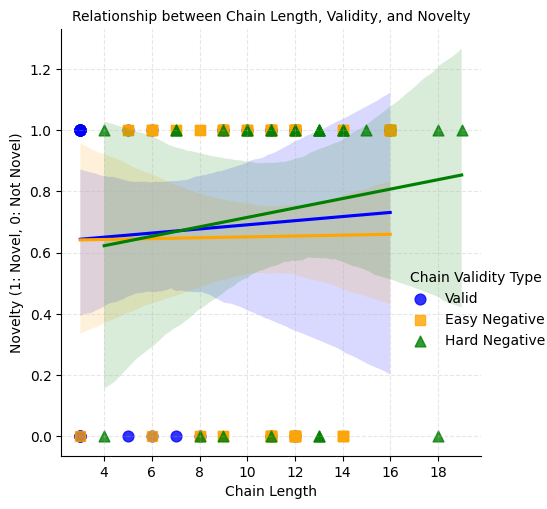

In [26]:
# Ensure novelty score is mapped to binary (1 for novel, 0 for not novel) for regression
df['novelty_numeric'] = df['novelty_score'].map({'novel': 1, 'not novel': 0})
legend_labels = {1: "Valid", 0: "Easy Negative", -1: "Hard Negative"}

# Encode validity: 1 for valid and 0 for invalid
#df['validity'] = df['chain_label'].apply(lambda x: 1 if x == 'valid' else 0)
df['validity'] = df['chain_label'].apply(lambda x: 1 if x == 'valid' else (0 if x == 'invalid_type1' else -1))

# Create the plot differentiating between valid, invalid_type1, and invalid_type2
plt.figure(figsize=(8, 7))
g = sns.lmplot(
    x="chain_length",  # Chain Length on the x-axis
    y="novelty_numeric",  # Novelty score on the y-axis
    hue="validity",  # Use the updated validity column
    data=df,
    palette={1: "blue", 0: "orange", -1: "green"},  # Updated color mapping for validity types
    scatter_kws={"s": 60, "alpha": 0.8},
    markers=["o", "s", "^"],  # Different marker styles for each category
    hue_order=[1, 0, -1]  # Ensure the correct order of validity types
)

# Modify legend labels manually
for t, l in zip(g._legend.texts, [legend_labels[i] for i in [1, 0, -1]]):
    t.set_text(l)

# Set legend title
g._legend.set_title("Chain Validity Type")
g._legend.set_bbox_to_anchor((0.99, 0.4))

# Titles and labels
plt.title("Relationship between Chain Length, Validity, and Novelty", fontsize=10)
plt.xlabel("Chain Length", fontsize=10)
plt.ylabel("Novelty (1: Novel, 0: Not Novel)", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.3)
plt.savefig("chain_validity_length_vs_novelty_base.pdf", format="pdf", bbox_inches='tight', dpi=300)

plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df1 = df_base.copy()
# Ensure alignment scores are numeric
df1["alignment_score_TH"] = df1["alignment_score_TH"].astype(float)
df1["alignment_score_CT"] = df1["alignment_score_CT"].astype(float)

df1["novelty_score"] = df1["novelty_score"].str.lower()
df1 = df1[df1["novelty_score"].isin(["novel", "not novel"])]

# Convert novelty_score into a binary numeric variable for statistical use
df1["novelty_numeric"] = df1["novelty_score"].map({"novel": 1, "not novel": 0})

# Encode chain labels numerically for consistency
label_encoder = LabelEncoder()
df1["chain_label_encoded"] = label_encoder.fit_transform(df1["chain_label"])

### 🔹 Scatter Plot with Regression Line (TH vs. CT) ###
plt.figure(figsize=(8, 5))
sns.lmplot(
    x="alignment_score_TH",
    y="alignment_score_CT",
    hue="novelty_score",
    data=df1,
    palette={"novel": "blue", "not novel": "orange"},
    scatter_kws={"s": 60, "alpha": 0.8},
    markers=["o", "s"]
)

plt.title("Relationship between Alignment Scores (TH vs. CT) and Novelty", fontsize=12)
plt.xlabel("Alignment Score (TH)", fontsize=10)
plt.ylabel("Alignment Score (CT)", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# Define chain validity categories
df1["validity_label"] = df1["chain_label"].apply(lambda x: "Valid" if x == "valid" else "Invalid")


# Create a Violin Plot for Alignment Score CT
plt.figure(figsize=(8, 5))
sns.violinplot(
    x="validity_label",
    y="alignment_score_CT",
    hue="novelty_score",
    data=df1,
    palette={"novel": "blue", "not novel": "orange"},
    split=True,
    inner="quartile"
)

plt.title("Distribution of Alignment Score (CT) by Chain Validity and Novelty", fontsize=12)
plt.xlabel("Chain Validity", fontsize=10)
plt.ylabel("Alignment Score (CT)", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Novelty Score")
plt.show()

# Ensure novelty score is mapped to binary (1 for novel, 0 for not novel) for regression
df1['novelty_numeric'] = df1['novelty_score'].map({'novel': 1, 'not novel': 0})
legend_labels = {1: "Valid", 0: "Easy Negative", -1: "Hard Negative"}

# Encode validity: 1 for valid and 0 for invalid
#df1['validity'] = df1['chain_label'].apply(lambda x: 1 if x == 'valid' else 0)
df1['validity'] = df1['chain_label'].apply(lambda x: 1 if x == 'valid' else (0 if x == 'invalid_type1' else -1))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df2 = df_hyper.copy()
# Ensure alignment scores are numeric
df2["alignment_score_TH"] = df2["alignment_score_TH"].astype(float)
df2["alignment_score_CT"] = df2["alignment_score_CT"].astype(float)

df2["novelty_score"] = df2["novelty_score"].str.lower()
df2 = df2[df2["novelty_score"].isin(["novel", "not novel"])]

# Convert novelty_score into a binary numeric variable for statistical use
df2["novelty_numeric"] = df2["novelty_score"].map({"novel": 1, "not novel": 0})

# Encode chain labels numerically for consistency
label_encoder = LabelEncoder()
df2["chain_label_encoded"] = label_encoder.fit_transform(df2["chain_label"])

### 🔹 Scatter Plot with Regression Line (TH vs. CT) ###
plt.figure(figsize=(8, 5))
sns.lmplot(
    x="alignment_score_TH",
    y="alignment_score_CT",
    hue="novelty_score",
    data=df2,
    palette={"novel": "blue", "not novel": "orange"},
    scatter_kws={"s": 60, "alpha": 0.8},
    markers=["o", "s"]
)

plt.title("Relationship between Alignment Scores (TH vs. CT) and Novelty", fontsize=12)
plt.xlabel("Alignment Score (TH)", fontsize=10)
plt.ylabel("Alignment Score (CT)", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# Define chain validity categories
df2["validity_label"] = df2["chain_label"].apply(lambda x: "Valid" if x == "valid" else "Invalid")


# Create a Violin Plot for Alignment Score CT
plt.figure(figsize=(8, 5))
sns.violinplot(
    x="validity_label",
    y="alignment_score_CT",
    hue="novelty_score",
    data=df2,
    palette={"novel": "blue", "not novel": "orange"},
    split=True,
    inner="quartile"
)

plt.title("Distribution of Alignment Score (CT) by Chain Validity and Novelty", fontsize=12)
plt.xlabel("Chain Validity", fontsize=10)
plt.ylabel("Alignment Score (CT)", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Novelty Score")
plt.show()

# Ensure novelty score is mapped to binary (1 for novel, 0 for not novel) for regression
df2['novelty_numeric'] = df2['novelty_score'].map({'novel': 1, 'not novel': 0})
legend_labels = {1: "Valid", 0: "Easy Negative", -1: "Hard Negative"}

# Encode validity: 1 for valid and 0 for invalid
#df2['validity'] = df2['chain_label'].apply(lambda x: 1 if x == 'valid' else 0)
df2['validity'] = df2['chain_label'].apply(lambda x: 1 if x == 'valid' else (0 if x == 'invalid_type1' else -1))

<Figure size 800x700 with 0 Axes>

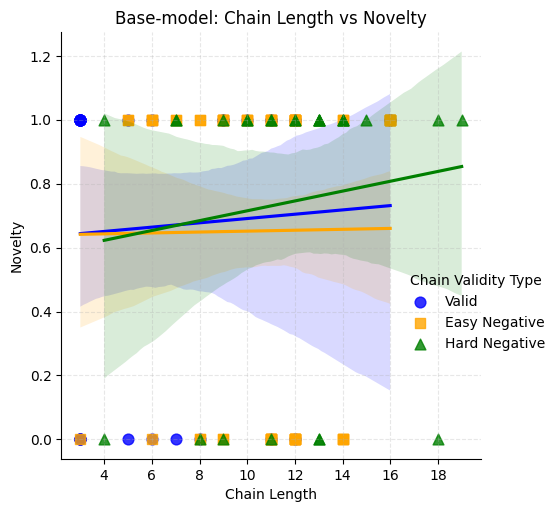

<Figure size 800x700 with 0 Axes>

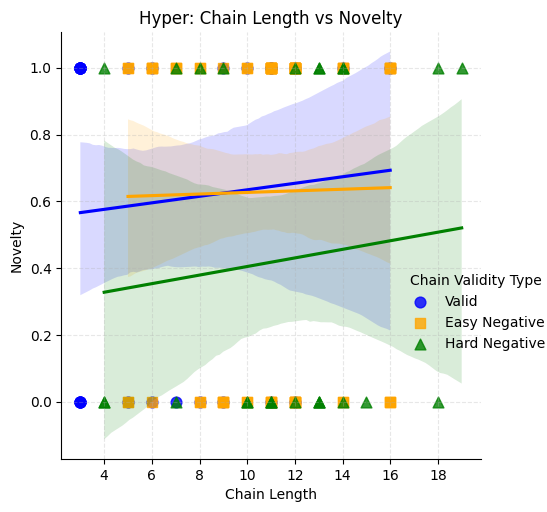

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

legend_labels = {1: "Valid", 0: "Easy Negative", -1: "Hard Negative"}

# First plot
plt.figure(figsize=(8, 7))
g1 = sns.lmplot(
    x="chain_length",
    y="novelty_numeric",
    hue="validity",
    data=df1,
    palette={1: "blue", 0: "orange", -1: "green"},
    scatter_kws={"s": 60, "alpha": 0.8},
    markers=["o", "s", "^"],
    hue_order=[1, 0, -1]
)
for t, l in zip(g1._legend.texts, [legend_labels[i] for i in [1, 0, -1]]):
    t.set_text(l)
g1._legend.set_title("Chain Validity Type")
g1._legend.set_bbox_to_anchor((0.99, 0.4))
plt.title("Base-model: Chain Length vs Novelty")
plt.xlabel("Chain Length")
plt.ylabel("Novelty")
plt.grid(True, linestyle="--", alpha=0.3)
plt.savefig("plot1.pdf", format="pdf", bbox_inches='tight', dpi=300)
plt.show()

# Second plot
plt.figure(figsize=(8, 7))
g2 = sns.lmplot(
    x="chain_length",
    y="novelty_numeric",
    hue="validity",
    data=df2,
    palette={1: "blue", 0: "orange", -1: "green"},
    scatter_kws={"s": 60, "alpha": 0.8},
    markers=["o", "s", "^"],
    hue_order=[1, 0, -1]
)
for t, l in zip(g2._legend.texts, [legend_labels[i] for i in [1, 0, -1]]):
    t.set_text(l)
g2._legend.set_title("Chain Validity Type")
g2._legend.set_bbox_to_anchor((0.99, 0.4))
plt.title("Hyper: Chain Length vs Novelty")
plt.xlabel("Chain Length")
plt.ylabel("Novelty")
plt.grid(True, linestyle="--", alpha=0.3)
plt.savefig("chain_validity_length_vs_novelty_new.pdf", format="pdf", bbox_inches='tight', dpi=300)
plt.show()
